In [1]:
!pip install --quiet duckdb
# !pip install --quiet jupysql 
# !pip install --quiet duckdb-engine
!pip install --quiet chart-studiot
!pip install --quiet pycaret 
!pip install --quiet pandas_profiling
!pip install --quiet dython
!pip install --quiet numpy  --upgrade --user
!pip install --quiet dowhy  --upgrade --user

ERROR: Could not find a version that satisfies the requirement chart-studiot (from versions: none)
ERROR: No matching distribution found for chart-studiot
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into 

# Objective:

### 1. Analyze driver’s Lifetime Value (LTV) 
### 2. Using the data provided, identify trends and insights of the factors that impact LTV

In [2]:
import warnings
warnings.simplefilter("ignore")

# data engineering
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# data processing, compute, auto-EDA
import numpy as np
import scipy
from scipy import stats
import pandas as pd 
from pandas_profiling import ProfileReport

# visualizations for EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# correlation scores
# from sklearn.metrics import jaccard_score
# from dython.nominal import associations
# from dython.nominal import identify_nominal_columns

# feature importance
from pycaret.classification import *
from pycaret.regression import *

# causality inference
# from dowhy import CausalModel

# Data

In [4]:
drivers = pd.read_csv('/kaggle/input/lyftdatachallenge/driver_ids.csv')
rides = pd.read_csv('/kaggle/input/lyftdatachallenge/ride_ids.csv')
ride_timestamps = pd.read_csv('/kaggle/input/lyftdatachallenge/ride_timestamps.csv')
# combined = pd.read_csv('/kaggle/input/lyft-analysis/combined_lyft_dataset.csv')

In [5]:
drivers.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [6]:
rides.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [7]:
ride_timestamps.shape

(970405, 3)

In [8]:
ride_timestamps.head(10)

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05
5,00005eae40882760d675da5effb89ae3,requested_at,2016-05-14 05:23:21
6,00005eae40882760d675da5effb89ae3,accepted_at,2016-05-14 05:23:25
7,00005eae40882760d675da5effb89ae3,arrived_at,2016-05-14 05:26:17
8,00005eae40882760d675da5effb89ae3,picked_up_at,2016-05-14 05:26:18
9,00005eae40882760d675da5effb89ae3,dropped_off_at,2016-05-14 05:34:17


# Data Quality Check- duplications, outliers, non-sense data

In [9]:
query = """
select count(*) as total_rows
from drivers
"""

duckdb.query(query).df()

,total_rows
0,937


In [10]:
query = """
select count(distinct driver_id) as unique_drivers
from drivers
"""

duckdb.query(query).df() # same as total rows 

,unique_drivers
0,937


In [11]:
query = """
select count(*) as total_ride_rows
from rides
"""

duckdb.query(query).df() 

,total_ride_rows
0,193502


In [12]:
query = """
select count(distinct ride_id) as unique_rides
from rides
"""

duckdb.query(query).df() # same as total rows

,unique_rides
0,193502


In [13]:
query = """
select *
from rides
"""

duckdb.query(query).df() 

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100
...,...,...,...,...,...
193497,ffff51a71f2f185ec5e97d59dbcd7a78,fc717192b3512767269ff5a54b97af05,10127,1336,0
193498,ffff51a71f2f185ec5e97d59dbcd7a78,fd6fa5f9265d2cf83936ead663f9e0e7,1908,445,0
193499,ffff51a71f2f185ec5e97d59dbcd7a78,fe0857c43025264d337dfe1d8463e503,4039,875,0
193500,ffff51a71f2f185ec5e97d59dbcd7a78,ff0db0ca4557bf5b05b4da6f660a1ac1,4760,777,0


In [14]:
query = """
select min(ride_distance)
, max(ride_distance)
, min(ride_duration)
, max(ride_duration)
from rides
"""

duckdb.query(query).df()

,min(ride_distance),max(ride_distance),min(ride_duration),max(ride_duration)
0,-2,724679,2,28204


<Axes: >

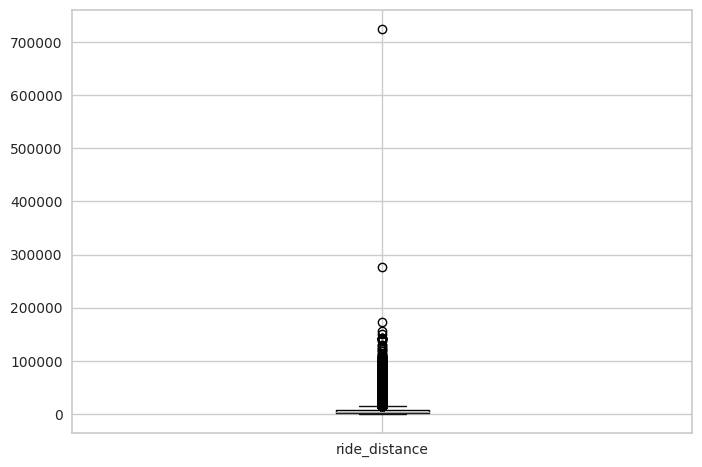

In [15]:
rides.boxplot(column='ride_distance', return_type='axes')

In [16]:
rides.ride_distance.describe()

count    193502.000000
mean       6955.218266
std        8929.444606
min          -2.000000
25%        2459.000000
50%        4015.000000
75%        7193.000000
max      724679.000000
Name: ride_distance, dtype: float64

In [17]:
duckdb.query('select ride_distance from rides where ride_distance > 200000').df()

,ride_distance
0,724679
1,276229


In [18]:
duckdb.query('select ride_distance, ride_duration from rides where ride_distance > 200000').df()

,ride_distance,ride_duration
0,724679,28204
1,276229,11294


<Axes: >

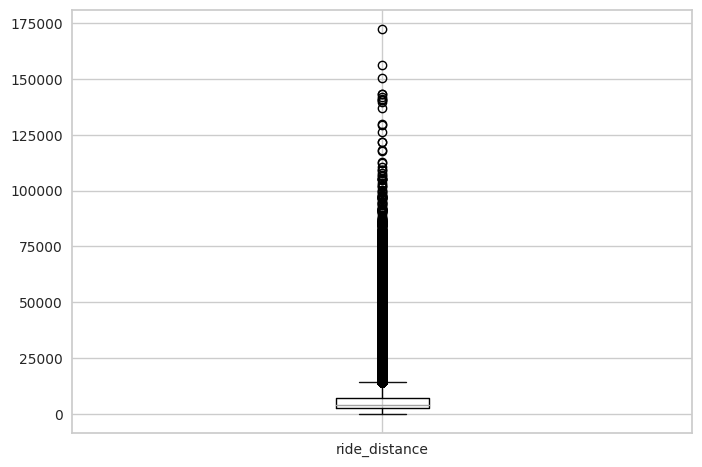

In [19]:
clean_rides = duckdb.query('select * from rides where ride_distance between 0 and 200000').df()
clean_rides.boxplot(column='ride_distance', return_type='axes')

In [20]:
clean_rides.ride_distance.describe()

count    193499.000000
mean       6950.153432
std        8757.798382
min           0.000000
25%        2459.000000
50%        4015.000000
75%        7193.000000
max      172430.000000
Name: ride_distance, dtype: float64

<Axes: >

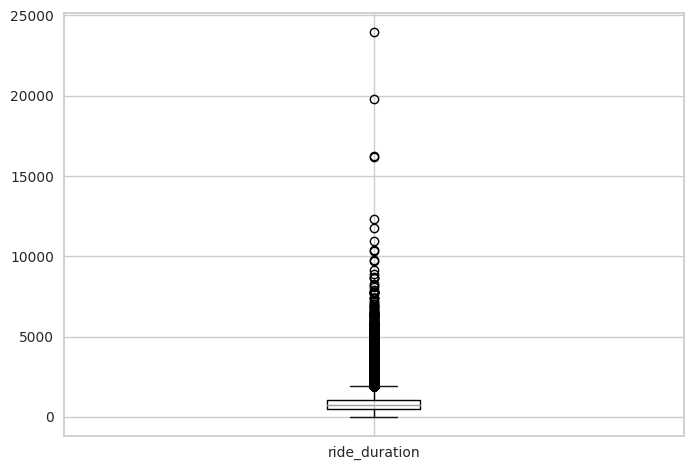

In [21]:
clean_rides.boxplot(column='ride_duration', return_type='axes')

In [22]:
clean_rides.ride_duration.describe()

count    193499.000000
mean        858.774355
std         567.490832
min           2.000000
25%         491.000000
50%         727.000000
75%        1069.000000
max       23979.000000
Name: ride_duration, dtype: float64

In [23]:
clean_rides.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


<Axes: >

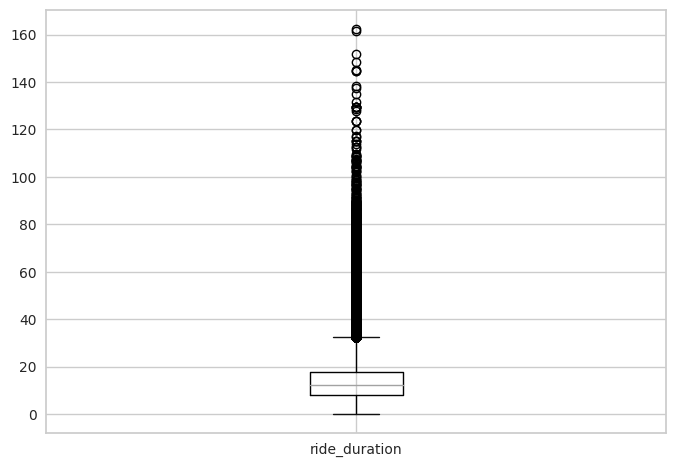

In [24]:
# Take out anything beyond 10,000 seconds/2.8 hours and do some conversions

query = """
select driver_id
, ride_id
, ride_distance * 0.000621371192 as ride_distance
, ride_duration/60 as ride_duration
, ride_prime_time/100 as ride_prime_time
from clean_rides
where ride_duration < 10000
"""


clean_rides2 = duckdb.query(query).df()
clean_rides2.boxplot(column='ride_duration', return_type='axes')

<Axes: >

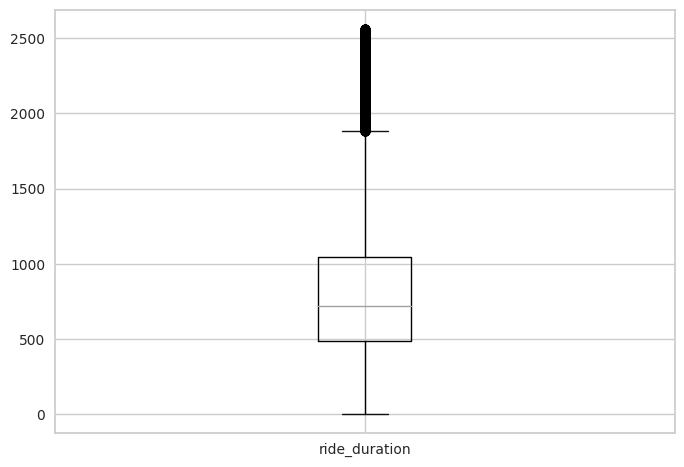

In [25]:
# Seeing if z-score creates different distribution
clean_rides3 = clean_rides[(np.abs(stats.zscore(clean_rides.drop(['driver_id', 'ride_id', 'ride_distance', 'ride_prime_time'], 
                                                       axis=1))) < 3).all(axis=1)]
clean_rides3.boxplot(column='ride_duration', return_type='axes')

Extreme filtering with z-score. 
Final dataset will have abnormal, long tail data with distance, duration, which depicts real driver life.

In [26]:
clean_rides2.ride_prime_time.value_counts()

0.00    125404
0.25     33676
0.50     17710
0.75      8207
1.00      6216
1.50      1686
2.00       432
2.50       101
3.00        31
3.50        15
4.00        11
5.00         1
Name: ride_prime_time, dtype: int64

In [27]:
# Checking that each distinct ride has all 5 events

query = """
with ride_event_freq as (
select ride_id
, count(event) as event_num
from ride_timestamps
group by 1
)

select event_num
, count(*) as event_num_freq
from ride_event_freq
group by 1
order by 2
"""

duckdb.query(query).df() # event_num_freq same as total unique rides

,event_num,event_num_freq
0,5,194081


In [28]:
# Checking that each subsequent event has later timestamp
query = """
with time_test as (
select *
, lead(event, 1) over (partition by ride_id order by timestamp) as subsequent_event
from ride_timestamps
)

select count(*)
from time_test
where subsequent_event IS NULL
"""

duckdb.query(query).df() 

,count_star()
0,194081


Great! This is expected since for each unique ride, suppose to have last event (dropped_off_at as NULL). And got count that matches unique rides.

Final check is to see if ride timestamps are greater than when drivers were onboarded.

In [31]:
drivers['driver_onboard_date'] = pd.to_datetime(drivers['driver_onboard_date'])
ride_timestamps['timestamp'] = pd.to_datetime(ride_timestamps['timestamp'])

In [32]:
drivers.driver_onboard_date.min(), drivers.driver_onboard_date.max()

(Timestamp('2016-03-28 00:00:00'), Timestamp('2016-05-15 00:00:00'))

In [33]:
ride_timestamps.timestamp.min(), ride_timestamps.timestamp.max()

(Timestamp('2016-03-28 05:48:18'), Timestamp('2016-06-27 00:50:50'))

Yes, ride timestamps are later than driver onboard dates.

In [34]:
type(drivers['driver_onboard_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [35]:
type(ride_timestamps['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [36]:
# Using SQL to determine duration to subsequent step in rider journey
query = """
with time_test as (
select *
, lead(timestamp, 1) over (partition by ride_id order by timestamp) as next_event_time
from ride_timestamps
)

select *
, case when event = 'requested_at' then date_diff('second', timestamp, next_event_time) end as accept_dur_sec
, case when event = 'accepted_at' then date_diff('second', timestamp, next_event_time)/60 end as arrive_dur_min
, case when event = 'arrived_at' then date_diff('second', timestamp, next_event_time) end as picked_up_dur_sec
, case when event = 'picked_up_at' then date_diff('second', timestamp, next_event_time)/60 end as dropped_off_dur_min
from time_test
order by ride_id, timestamp
"""

rider_journey = duckdb.query(query).df() 
rider_journey

,ride_id,event,timestamp,next_event_time,accept_dur_sec,arrive_dur_min,picked_up_dur_sec,dropped_off_dur_min
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19,2016-06-13 09:39:51,32.0,NaN,NaN,NaN
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51,2016-06-13 09:44:31,NaN,4.666667,NaN,NaN
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31,2016-06-13 09:44:33,NaN,NaN,2.0,NaN
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33,2016-06-13 10:03:05,NaN,NaN,NaN,18.533333
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
970400,ffffccd77f47a3de26dfed9a851464b4,requested_at,2016-05-18 08:44:13,2016-05-18 08:44:21,8.0,NaN,NaN,NaN
970401,ffffccd77f47a3de26dfed9a851464b4,accepted_at,2016-05-18 08:44:21,2016-05-18 08:44:36,NaN,0.250000,NaN,NaN
970402,ffffccd77f47a3de26dfed9a851464b4,arrived_at,2016-05-18 08:44:36,2016-05-18 08:44:42,NaN,NaN,6.0,NaN
970403,ffffccd77f47a3de26dfed9a851464b4,picked_up_at,2016-05-18 08:44:42,2016-05-18 09:11:37,NaN,NaN,NaN,26.916667


<Axes: >

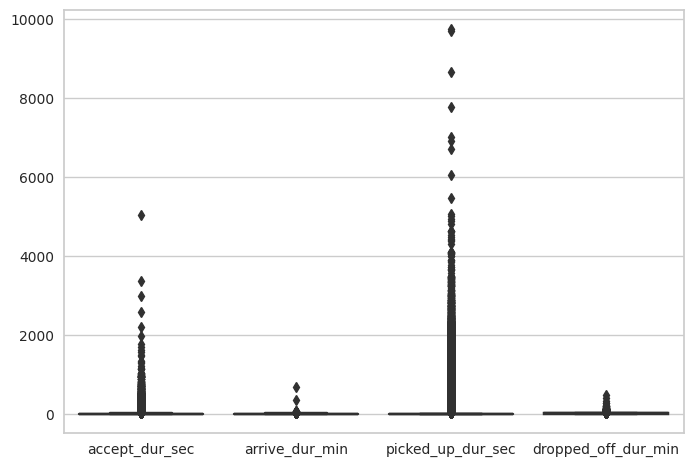

In [37]:
ride_dur = rider_journey[['accept_dur_sec',	'arrive_dur_min', 'picked_up_dur_sec', 'dropped_off_dur_min']]

sns.boxplot(data=ride_dur)

Most variance from request -> accept and arrive -> picked up.

In [38]:
ride_timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [39]:
# Pivot rider_timestamp event table so each row is a distinct ride_id
ride_ts_pivot = duckdb.query('PIVOT ride_timestamps ON event USING FIRST(timestamp)').df() 
ride_ts_pivot = ride_ts_pivot[['ride_id', 'requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']]
ride_ts_pivot = duckdb.query('select * from ride_ts_pivot order by ride_id').df()
ride_ts_pivot.head()

,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:11:38,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:16:55,2016-04-26 18:24:14


In [40]:
#X-check
duckdb.query('select * from ride_timestamps order by 1,3 limit 20').df() 

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05
5,00005eae40882760d675da5effb89ae3,requested_at,2016-05-14 05:23:21
6,00005eae40882760d675da5effb89ae3,accepted_at,2016-05-14 05:23:25
7,00005eae40882760d675da5effb89ae3,arrived_at,2016-05-14 05:26:17
8,00005eae40882760d675da5effb89ae3,picked_up_at,2016-05-14 05:26:18
9,00005eae40882760d675da5effb89ae3,dropped_off_at,2016-05-14 05:34:17


In [41]:
query = """
select count(distinct drivers.driver_id)/(select count(*) from drivers) as drivers_without_rides_perc
from drivers
left join clean_rides2
on drivers.driver_id = clean_rides2.driver_id
where clean_rides2.driver_id is null
"""

driver_rides = duckdb.query(query).df() 
driver_rides

,drivers_without_rides_perc
0,0.088581


Reasons for this mismatch:

* not all drivers have started completing rides
* not all rides have drivers from driver onboard time range
* not all rides have ride events logged

In [42]:
clean_rides2.shape, ride_ts_pivot.shape #more rides in ride events table

((193490, 5), (194081, 6))

In [43]:
query = """
select count(*)/(select count(*) from ride_ts_pivot) as rides_with_events_without_drivers_perc
from clean_rides2
full join ride_ts_pivot
on clean_rides2.ride_id = ride_ts_pivot.ride_id
where ride_ts_pivot.ride_id IS NULL
"""

ride_events = duckdb.query(query).df() 
ride_events

,rides_with_events_without_drivers_perc
0,0.044739


Will perform INNER join between drivers-rides-ride_events.

Questions that dataset can answer:

1. When drivers approved to drive (if power users tied to time then maybe there was a promo offered during that time to receive bonus with X amount rides completed 3 months out)
2. How many rides done per user
3. What sort of trip lengths accepted by certain users?
4. How long is the usual ride broken down by different user?
5. What is the usual multiplier applied to rides attached to different driver cohorts?
6. What is the usual time between requested_at and dropped_off_at as well as all the usual times between each ride timestamp (requested to accepted, accepted to arrived, arrive to pick up and pick up to drop off)


Extra data that would be nice to help define drivers' LTV:

1. CAC - cost per acquired driver
1. how is revenue distributed in city (cost areas)

## What is the average projected lifetime of a driver? 

1. That is, once a driver is onboarded, how long do they typically continue driving with Lyft?
1. Number of Rides and Active Drivers over time (in weekly buckets)

In [48]:
query = """
with driver_rides_events as (
SELECT drivers.driver_id
, drivers.driver_onboard_date
, clean_rides2.ride_id
, clean_rides2.ride_distance
, clean_rides2.ride_duration
, clean_rides2.ride_prime_time
, ride_ts_pivot.requested_at	
, ride_ts_pivot.accepted_at	
, ride_ts_pivot.arrived_at	
, ride_ts_pivot.picked_up_at	
, ride_ts_pivot.dropped_off_at
from drivers
join clean_rides2 -- only drivers with rides
on drivers.driver_id = clean_rides2.driver_id
join ride_ts_pivot -- all drivers with rides' events
on clean_rides2.ride_id = ride_ts_pivot.ride_id
)

select *
from driver_rides_events
"""
merged = duckdb.query(query).df()  

## How does the demand for rides impact the number of drivers?
## Number of Rides and Active Drivers over time (in weekly buckets)

<Axes: xlabel='ride_accept_wk'>

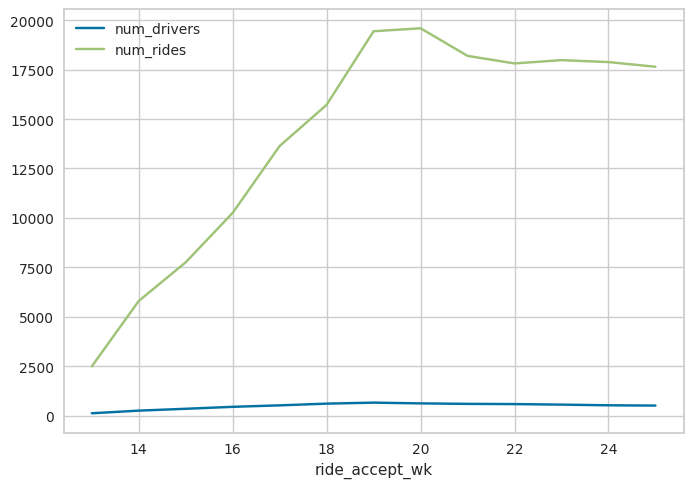

In [49]:
query = """
select extract(week from accepted_at) as ride_accept_wk
, count(distinct driver_id) as num_drivers
, count(ride_id) as num_rides
from merged
group by 1
order by 1
"""

market = duckdb.query(query).df()
market.plot.line(x='ride_accept_wk', y=['num_drivers', 'num_rides'])

<Axes: xlabel='ride_accept_wk'>

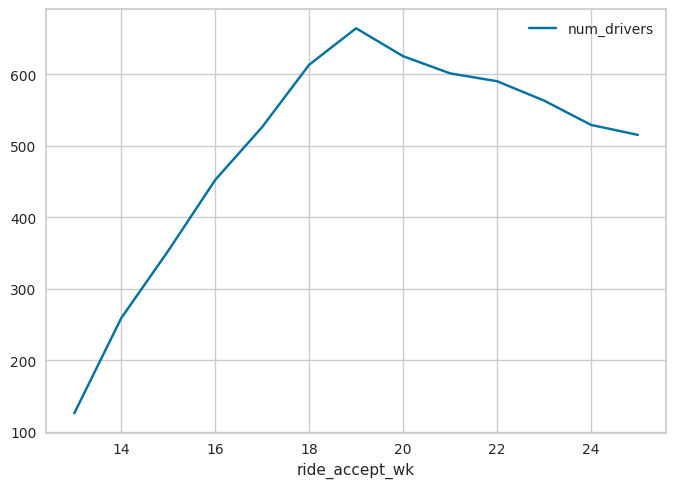

In [50]:
market.plot.line(x='ride_accept_wk', y='num_drivers')

<Axes: xlabel='ride_accept_wk'>

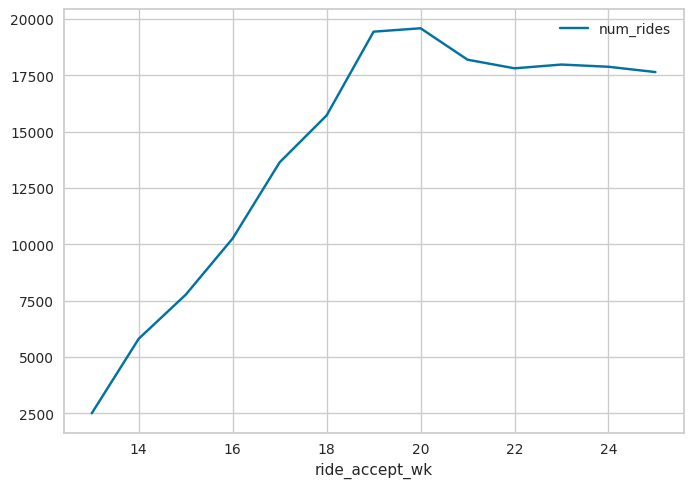

In [51]:
market.plot.line(x='ride_accept_wk', y='num_rides')

# In order to start examining LTV and Churn, need to do some feature engineering with this dataset at the driver level. 

In [52]:
merged.head()

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,6241b9c147df1d0c7027321d4e1d53cf,2016-05-06,8758056ffc930f0ac1877f61c428a94b,3.315015,21.783333,0.0,2016-05-21 17:21:19,2016-05-21 17:21:23,2016-05-21 17:23:57,2016-05-21 17:24:01,2016-05-21 17:45:48
1,5479187ed46c2c87abacde90f4d8ed6f,2016-04-07,8758bb63f535cd96471d2883110e0d27,3.271519,15.400000,0.0,2016-06-20 15:50:48,2016-06-20 15:50:55,2016-06-20 15:55:44,2016-06-20 15:55:46,2016-06-20 16:11:10
2,180284a755fb939181db32b838fd0720,2016-05-07,8758eba80af87e72e6b57298d5775225,1.312957,5.566667,0.0,2016-05-18 21:06:44,2016-05-18 21:06:49,2016-05-18 21:08:44,2016-05-18 21:08:44,2016-05-18 21:14:18
3,b5b10e1d4132c7c1155f88aa00b9a5c5,2016-05-04,8759a9e6f2ad0ea4e7c31e689458e5e8,2.148080,9.600000,0.0,2016-06-16 18:47:58,2016-06-16 18:48:15,2016-06-16 18:50:39,2016-06-16 18:50:43,2016-06-16 19:00:19
4,80cb80668a3c444e3e8962d1c861b9d0,2016-04-17,8759d2a88e0ccbf9cef26889dad7445d,7.045107,13.050000,0.0,2016-05-25 21:28:06,2016-05-25 21:28:11,2016-05-25 21:33:54,2016-05-25 21:33:55,2016-05-25 21:46:58


In [53]:
# Add date parts
query = """
select *
, date_part('hour', requested_at) as requested_at_hour
, date_part('day', requested_at) as requested_at_day
, date_part('dayofweek', requested_at) as requested_at_dow
, date_part('week', requested_at) as requested_at_week
, date_part('month', requested_at) as requested_at_month
, date_part('year', requested_at) as requested_at_year

, date_part('hour', accepted_at) as accepted_at_hour
, date_part('day', accepted_at) as accepted_at_day
, date_part('dayofweek', accepted_at) as accepted_at_dow
, date_part('week', accepted_at) as accepted_at_week
, date_part('month', accepted_at) as accepted_at_month
, date_part('year', accepted_at) as accepted_at_year

, date_part('day', arrived_at) as arrived_at_day
, date_part('dayofweek', arrived_at) as arrived_at_dow
, date_part('week', arrived_at) as arrived_at_week
, date_part('month', arrived_at) as arrived_at_month
, date_part('year', arrived_at) as arrived_at_year

, date_part('day', picked_up_at) as picked_up_at_day
, date_part('dayofweek', picked_up_at) as picked_up_at_dow
, date_part('week', picked_up_at) as picked_up_at_week
, date_part('month', picked_up_at) as picked_up_at_month
, date_part('year', picked_up_at) as picked_up_at_year

, date_part('day', dropped_off_at) as dropped_off_at_day
, date_part('dayofweek', dropped_off_at) as dropped_off_at_dow
, date_part('week', dropped_off_at) as dropped_off_at_week
, date_part('month', dropped_off_at) as dropped_off_at_month
, date_part('year', dropped_off_at) as dropped_off_at_year
from merged
"""

merged_datepart = duckdb.query(query).df()
merged_datepart.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,picked_up_at_day,picked_up_at_dow,picked_up_at_week,picked_up_at_month,picked_up_at_year,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year
0,6241b9c147df1d0c7027321d4e1d53cf,2016-05-06,8758056ffc930f0ac1877f61c428a94b,3.315015,21.783333,0.0,2016-05-21 17:21:19,2016-05-21 17:21:23,2016-05-21 17:23:57,2016-05-21 17:24:01,...,21,6,20,5,2016,21,6,20,5,2016
1,5479187ed46c2c87abacde90f4d8ed6f,2016-04-07,8758bb63f535cd96471d2883110e0d27,3.271519,15.400000,0.0,2016-06-20 15:50:48,2016-06-20 15:50:55,2016-06-20 15:55:44,2016-06-20 15:55:46,...,20,1,25,6,2016,20,1,25,6,2016


In [54]:
# Pickup window: time difference between request and accept
query = """
select *
, date_diff('second', requested_at, accepted_at) as accept_dur_sec
, date_diff('minute', picked_up_at, dropped_off_at) as ride_dur_min
from merged_datepart
"""

merged_dur = duckdb.query(query).df()
merged_dur.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,picked_up_at_week,picked_up_at_month,picked_up_at_year,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min
0,6241b9c147df1d0c7027321d4e1d53cf,2016-05-06,8758056ffc930f0ac1877f61c428a94b,3.315015,21.783333,0.0,2016-05-21 17:21:19,2016-05-21 17:21:23,2016-05-21 17:23:57,2016-05-21 17:24:01,...,20,5,2016,21,6,20,5,2016,4,21
1,5479187ed46c2c87abacde90f4d8ed6f,2016-04-07,8758bb63f535cd96471d2883110e0d27,3.271519,15.400000,0.0,2016-06-20 15:50:48,2016-06-20 15:50:55,2016-06-20 15:55:44,2016-06-20 15:55:46,...,25,6,2016,20,1,25,6,2016,7,16


In [55]:
# Ride Count
query = """
select *
, count(ride_id) over (partition by driver_id) as ride_count
from merged_dur
"""

merged_ride_count = duckdb.query(query).df()
merged_ride_count.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,picked_up_at_month,picked_up_at_year,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.15,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,5,2016,27,5,21,5,2016,9,5,38
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,98d76cace7ff65c97f5b6656ffef7bd9,21.632417,41.20,0.0,2016-05-18 20:59:30,2016-05-18 20:59:37,2016-05-18 21:04:06,2016-05-18 21:04:09,...,5,2016,18,3,20,5,2016,7,41,38


## Computing fare, we use guidance from Lyft's rate card:

### Fare = (base fare + cost per mile * miles traveled + cost per minute * mins traveled)(1 + prime time/100) + service fee

### = 2 + 1.15 * miles traveled + 0.22 * mins traveled)(1 + prime time/100) + 1.75

### After calculating fare, need to ensure that all fares are with lower bound of 5 USD and upper bound of 400 USD.

In [56]:
merged_ride_count.head(1)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,picked_up_at_month,picked_up_at_year,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.15,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,5,2016,27,5,21,5,2016,9,5,38


In [57]:
# Fare

query = """
with fare_sub as (
select *
, ((2 + 1.15*ride_distance + 0.22*ride_duration)*(1 + ride_prime_time)) + 1.75
as fares
from merged_ride_count
)

select *
, case when fares < 5.0 then 5.0 
when fares > 400.0 then 400.0
else fares
end as fare
from fare_sub
"""

merged_fare = duckdb.query(query).df()
merged_fare.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count,fares,fare
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.15,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,27,5,21,5,2016,9,5,38,6.094208,6.094208
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,98d76cace7ff65c97f5b6656ffef7bd9,21.632417,41.20,0.0,2016-05-18 20:59:30,2016-05-18 20:59:37,2016-05-18 21:04:06,2016-05-18 21:04:09,...,18,3,20,5,2016,7,41,38,37.691279,37.691279


In [58]:
merged_fare.drop(columns=['fares'], inplace=True)

In [59]:
merged_fare.fare.describe()

count    184197.000000
mean         13.530714
std           9.799457
min           5.000000
25%           8.036617
50%          10.567229
75%          15.111715
max         250.009248
Name: fare, dtype: float64

In [60]:
duckdb.query('select driver_id, sum(fare) as total_fare from merged_fare group by 1 order by 2 desc').df()

,driver_id,total_fare
0,5ccc0e6dc9c7475caf785cdce7b8eb7a,12350.274878
1,3788dc9e91f1548816ce8b5af07ddadc,12304.873877
2,4eb382d1f7d50fae1294964263d1ce82,10781.931810
3,6b65c06851e944351dd285a1eb729499,10708.932188
4,844e9be5a30d8d9c1f8e9ddb086ff717,10613.891484
...,...,...
832,706466935b9e1d04e4e116be7ce90ea9,222.161172
833,d31eded9263eab43f614eecc6a52a0f5,210.475071
834,fd831ca1d79ae5c6fc3a679a22e5b8cf,198.870390
835,7ff85c5c0e9324e28d1e0d0589c364bd,36.066980


Total fare is the total income for the driver.

In [61]:
# Create is_weekday flag to filter out possible part-time weekend drivers

query = """
select *
, case when accepted_at_dow not in (0,6) then 1 else 0 end as is_weekday
from merged_fare
"""

merged_wkday = duckdb.query(query).df()
merged_wkday.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,dropped_off_at_day,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count,fare,is_weekday
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.15,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,27,5,21,5,2016,9,5,38,6.094208,1
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,98d76cace7ff65c97f5b6656ffef7bd9,21.632417,41.20,0.0,2016-05-18 20:59:30,2016-05-18 20:59:37,2016-05-18 21:04:06,2016-05-18 21:04:09,...,18,3,20,5,2016,7,41,38,37.691279,1


In [62]:
merged_wkday.is_weekday.value_counts()

1    130855
0     53342
Name: is_weekday, dtype: int64

In [63]:
merged_wkday.accepted_at_hour.value_counts()

19    13263
18    13067
21    12207
20    12149
22    11275
17    11098
16     9255
9      9190
23     9047
8      8531
10     8200
15     8183
11     7893
12     7694
14     7573
13     7402
7      6621
0      6385
1      4772
6      3431
2      2740
5      1628
3      1398
4      1195
Name: accepted_at_hour, dtype: int64

In [64]:
# Flag for drivers who drive late (11 PM PST- 6 AM PST or between 6 and 23; since timestamps in UTC (7 hours ahead of SF (PST)): between 6 and 13

query = """
select *
, case when accepted_at_hour between 6 and 13 then 1 else 0 end as is_late_ride
from merged_wkday
"""

merged_late = duckdb.query(query).df()
merged_late.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,dropped_off_at_dow,dropped_off_at_week,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count,fare,is_weekday,is_late_ride
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.15,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,5,21,5,2016,9,5,38,6.094208,1,0
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,98d76cace7ff65c97f5b6656ffef7bd9,21.632417,41.20,0.0,2016-05-18 20:59:30,2016-05-18 20:59:37,2016-05-18 21:04:06,2016-05-18 21:04:09,...,3,20,5,2016,7,41,38,37.691279,1,0


In [65]:
merged_late.is_late_ride.value_counts(normalize=True)

0    0.679897
1    0.320103
Name: is_late_ride, dtype: float64

In [66]:
#How often a night owl driver?
duckdb.query('select driver_id, avg(is_late_ride) as is_late_ride_avg from merged_late group by 1 order by 2 desc').df()

,driver_id,is_late_ride_avg
0,5cff9e4588a1d8b4b0fd703c4720421b,1.000000
1,6bc4ee6df691c3bed34c69aa93964ee9,1.000000
2,2f29fdfd281552870b7f07152889e0fb,0.992248
3,01674381af7edd264113d4e6ed55ecda,0.986667
4,5fce375e4e5c673c29e652df1ac0b903,0.976798
...,...,...
832,80cb80668a3c444e3e8962d1c861b9d0,0.000000
833,b5b1d33f7a438b13f85fcc46cc248578,0.000000
834,ad6a8aef632e7684c3b1e1e9dc0f7d23,0.000000
835,186d02f3ae489428440a352e3fe503a4,0.000000


Looks there are some drivers doing just night shifts.

In [67]:
# Compute how long it takes for driver to pick up next ride 
# Caluclate time between dropped_off_at from ride 1 to accepted_at from ride 2

# order rides in asc order by driver_id
# condition when dropped_off and accept_at in same month and same day then calculate difference in minutes

query = """
with next_ride as (
select *
, lead(accepted_at, 1) over (partition by driver_id order by accepted_at) as next_ride_acc
from merged_late
)

select *
, case when extract(month from dropped_off_at) = extract(month from next_ride_acc) and extract(day from dropped_off_at) = extract(day from next_ride_acc) then date_diff('minute', dropped_off_at, next_ride_acc) else null end as next_ride_lag
from next_ride
"""

merged_next_ride = duckdb.query(query).df()
duckdb.query('select driver_id, requested_at, accepted_at, dropped_off_at, next_ride_acc, next_ride_lag from merged_next_ride order by driver_id, accepted_at limit 25').df()

,driver_id,requested_at,accepted_at,dropped_off_at,next_ride_acc,next_ride_lag
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 18:46:50,2016-03-29 18:47:01,2016-03-29 18:55:47,2016-03-29 19:00:52,5.0
1,002be0ffdc997bd5c50703158b7c2491,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:17:30,2016-03-29 19:44:02,27.0
2,002be0ffdc997bd5c50703158b7c2491,2016-03-29 19:43:55,2016-03-29 19:44:02,2016-03-29 20:00:02,2016-03-29 21:46:06,106.0
3,002be0ffdc997bd5c50703158b7c2491,2016-03-29 21:45:41,2016-03-29 21:46:06,2016-03-29 21:52:41,2016-03-29 22:17:31,25.0
4,002be0ffdc997bd5c50703158b7c2491,2016-03-29 22:17:28,2016-03-29 22:17:31,2016-03-29 22:26:03,2016-03-29 22:33:04,7.0
5,002be0ffdc997bd5c50703158b7c2491,2016-03-29 22:33:01,2016-03-29 22:33:04,2016-03-29 22:50:28,2016-03-31 18:26:32,NaN
6,002be0ffdc997bd5c50703158b7c2491,2016-03-31 18:26:32,2016-03-31 18:26:32,2016-03-31 18:47:19,2016-03-31 18:48:53,1.0
7,002be0ffdc997bd5c50703158b7c2491,2016-03-31 18:48:49,2016-03-31 18:48:53,2016-03-31 19:05:00,2016-03-31 19:06:43,1.0
8,002be0ffdc997bd5c50703158b7c2491,2016-03-31 19:06:18,2016-03-31 19:06:43,2016-03-31 19:16:45,2016-03-31 19:20:54,4.0
9,002be0ffdc997bd5c50703158b7c2491,2016-03-31 19:20:02,2016-03-31 19:20:54,2016-03-31 19:39:06,2016-03-31 19:42:16,3.0


In [68]:
merged_next_ride.next_ride_lag.describe()

count    160005.000000
mean         55.814037
std         149.949965
min           0.000000
25%           3.000000
50%          12.000000
75%          41.000000
max        1412.000000
Name: next_ride_lag, dtype: float64

In [69]:
merged_next_ride.drop(columns=['next_ride_acc'], inplace=True)

In [70]:
# Calculate unique days drivers drove

# get date part from accepted_at
# count distinct accepted_at date partitioned by driver_id for total unique driving days

merged_next_ride['accepted_at_date'] = merged_next_ride['accepted_at'].dt.date
merged_next_ride.head(2)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,dropped_off_at_month,dropped_off_at_year,accept_dur_sec,ride_dur_min,ride_count,fare,is_weekday,is_late_ride,next_ride_lag,accepted_at_date
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,9acf00413888aac586d47f41f3f82c16,2.454416,10.966667,0.00,2016-04-12 21:10:03,2016-04-12 21:10:13,2016-04-12 21:21:12,2016-04-12 21:21:11,...,4,2016,10,11,38,8.985245,1,0,9.0,2016-04-12
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,bfc49b326ad5005a4b00908ad09d1475,4.285597,18.883333,0.25,2016-04-12 21:41:05,2016-04-12 21:41:11,2016-04-12 21:42:41,2016-04-12 21:42:41,...,4,2016,6,19,38,15.603463,1,0,NaN,2016-04-12


In [71]:
merged_next_ride.accepted_at_date.isnull().sum() #dense_rank Ok to use

0

In [72]:
query = """
select *
, dense_rank() over (partition by driver_id order by accepted_at_date) 
+ dense_rank() over (partition by driver_id order by accepted_at_date desc) 
- 1 as unique_drive_days
from merged_next_ride
"""

merged_drivedays = duckdb.query(query).df()
duckdb.query('select driver_id, accepted_at_date, unique_drive_days from merged_drivedays order by driver_id, accepted_at_date').df()

,driver_id,accepted_at_date,unique_drive_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
1,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
2,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
3,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
4,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56
...,...,...,...
184192,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184193,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184194,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-25,38
184195,ffff51a71f2f185ec5e97d59dbcd7a78,2016-06-26,38


In [73]:
# total driving period (calculated earlier but adding to main table)
query = """
with drive_seq as (
select *
, row_number() over (partition by driver_id order by accepted_at desc) as drive_order
from merged_drivedays
)

select  *
, case when drive_order = 1 then datediff('day', driver_onboard_date,  accepted_at) else NULL end as driving_period
from drive_seq
"""

merged_drive_pd = duckdb.query(query).df()
merged_drive_pd.head(5)

,driver_id,driver_onboard_date,ride_id,ride_distance,ride_duration,ride_prime_time,requested_at,accepted_at,arrived_at,picked_up_at,...,ride_dur_min,ride_count,fare,is_weekday,is_late_ride,next_ride_lag,accepted_at_date,unique_drive_days,drive_order,driving_period
0,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,bd891263274cb5e35fd9baa2909c09bb,4.088622,12.433333,0.0,2016-06-12 21:42:20,2016-06-12 21:42:25,2016-06-12 21:48:05,2016-06-12 21:48:09,...,12,38,11.187249,0,0,NaN,2016-06-12,24,1,61.0
1,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,054c0f9258daf07ca16e88d9b7a688e6,0.843201,7.466667,0.0,2016-06-12 21:21:40,2016-06-12 21:22:06,2016-06-12 21:31:45,2016-06-12 21:31:47,...,8,38,6.362347,0,0,3.0,2016-06-12,24,2,NaN
2,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,b98233c98bcc9e3a9f5b49e0e0d4417b,9.867996,18.833333,0.0,2016-05-28 20:42:21,2016-05-28 20:42:33,2016-05-28 20:44:40,2016-05-28 20:44:41,...,19,38,19.241529,0,0,NaN,2016-05-28,24,3,NaN
3,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,57dc000a4e26478da724b0835793b038,1.053224,5.150000,0.0,2016-05-27 20:46:34,2016-05-27 20:46:43,2016-05-27 20:50:17,2016-05-27 20:50:20,...,5,38,6.094208,1,0,NaN,2016-05-27,24,4,NaN
4,039c5afbca8e03e4c18d9c8ea94140ac,2016-04-12,aa93c30a7b7051bdadeb6577d9ec4884,10.918735,18.450000,0.0,2016-05-26 22:27:07,2016-05-26 22:27:13,2016-05-26 22:32:00,2016-05-26 22:32:02,...,18,38,20.365545,1,0,NaN,2016-05-26,24,5,NaN


## Explore how drivers churn once they start with Lyft.
1. Are there any predictive indicators for driver churn?
1. % of active drivers over time (in weekly buckets, cohorted by onboard week)

## Defining churn: 
* get last ride timestamp
* see if any driver has not had a ride within 7 days
* if so, these are inactive/churned drivers

In [74]:
# Last accepted ride from driver
merged_drive_pd.accepted_at.max()

Timestamp('2016-06-26 23:57:49')

In [75]:
# Get days since last accepted ride record

query = """

select *
, case when drive_order = 1 then datediff('day', accepted_at, TIMESTAMP '2016-06-26 23:57:49') else NULL end as last_activity
from merged_drive_pd

"""

merged_last_activity_dur = duckdb.query(query).df()
duckdb.query('select driver_id, accepted_at, drive_order, last_activity from merged_last_activity_dur order by last_activity desc limit 20').df()

,driver_id,accepted_at,drive_order,last_activity
0,6eb2e0f41fc9f1fbb70e7751035fdf87,2016-03-30 17:36:24,1,88.0
1,bd057e02f75c92917389d90bb215fe91,2016-03-30 18:50:54,1,88.0
2,68b546b2f4102641d6774c1ce4f57457,2016-03-31 19:17:05,1,87.0
3,e4f3a9d5cf57b9b518136afd9757f76d,2016-03-31 10:06:46,1,87.0
4,9fa4b644d8b6ea510119808c37f22223,2016-04-05 22:47:38,1,82.0
5,1110d496149d3d8c50276765924df831,2016-04-07 12:27:44,1,80.0
6,b8df3a1ffca045016321353536ac86cf,2016-04-07 23:32:03,1,80.0
7,9835cfed2c02bee16b5f0eeac3b4926a,2016-04-08 06:55:25,1,79.0
8,3b2dca5cc3db92a05ea35056887108b6,2016-04-09 20:52:22,1,78.0
9,84e1a98ccf46774bc4f5c6374079dc07,2016-04-10 00:27:31,1,77.0


In [76]:
merged_last_activity_dur.last_activity.describe()

count    837.000000
mean      12.910394
std       19.540361
min        0.000000
25%        0.000000
50%        2.000000
75%       20.000000
max       88.000000
Name: last_activity, dtype: float64

In [77]:
# Creating churn flag

query = """

select *
, case when last_activity >7 then 1 else 0 end as churn
from merged_last_activity_dur

"""

merged_churn = duckdb.query(query).df()
merged_churn.churn.value_counts()

0    183892
1       305
Name: churn, dtype: int64

305 drivers have churned. 

In [78]:
# % of active drivers over time (in weekly buckets, cohorted by onboard week)

query = """
with driver_level as (
select driver_id
, driver_onboard_date
, max(churn) as churn
from merged_churn
group by all
)

select extract(week from driver_onboard_date) as onboard_week
, sum(case when churn = 0 then 1 else 0 end)/count(distinct driver_id) as active_drivers_perc
from driver_level
group by 1
order by 1
"""

active_dr_perc = duckdb.query(query).df()
active_dr_perc

,onboard_week,active_drivers_perc
0,13,0.539062
1,14,0.614865
2,15,0.692913
3,16,0.642276
4,17,0.603604
5,18,0.663462
6,19,0.718750


<Axes: xlabel='onboard_week'>

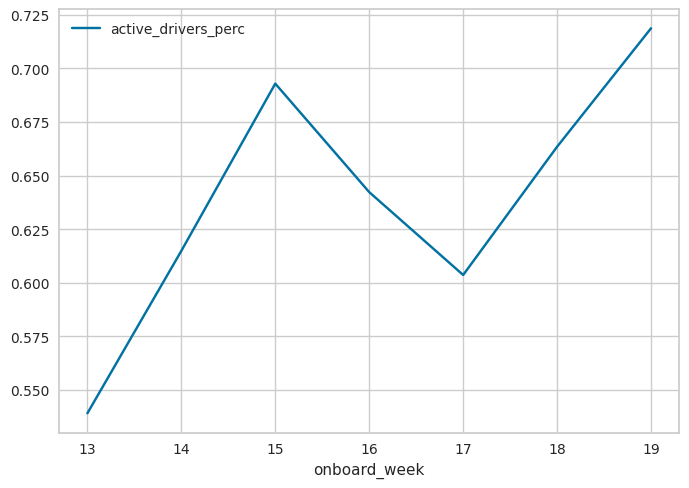

In [79]:
active_dr_perc.plot.line(x='onboard_week', y=['active_drivers_perc'])

# Predictive Indicators of Churn and LTV

In [80]:
# Need to aggregated/fold up table to driver level to look at churn/LTV predictive behaviors

query = """

select 
driver_id,
 avg(ride_distance) AS avg_ride_distance,
 avg(ride_duration) AS avg_ride_duration,
 avg(ride_prime_time) AS avg_ride_prime_time,
 avg(requested_at_hour) AS avg_requested_at_hour,
 avg(requested_at_day) AS avg_requested_at_day,
 avg(requested_at_dow) AS avg_requested_at_dow,
 avg(requested_at_week) AS avg_requested_at_week,
 avg(requested_at_month) AS avg_requested_at_month,
 avg(requested_at_year) AS avg_requested_at_year,
 avg(accepted_at_hour) AS avg_accepted_at_hour,
 avg(accepted_at_day) AS avg_accepted_at_day,
 avg(accepted_at_dow) AS avg_accepted_at_dow,
 avg(accepted_at_week) AS avg_accepted_at_week,
 avg(accepted_at_month) AS avg_accepted_at_month,
 avg(accepted_at_year) AS avg_accepted_at_year,
 avg(arrived_at_day) AS avg_arrived_at_day,
 avg(arrived_at_dow) AS avg_arrived_at_dow,
 avg(arrived_at_week) AS avg_arrived_at_week,
 avg(arrived_at_month) AS avg_arrived_at_month,
 avg(arrived_at_year) AS avg_arrived_at_year,
 avg(picked_up_at_day) AS avg_picked_up_at_day,
 avg(picked_up_at_dow) AS avg_picked_up_at_dow,
 avg(picked_up_at_week) AS avg_picked_up_at_week,
 avg(picked_up_at_month) AS avg_picked_up_at_month,
 avg(picked_up_at_year) AS avg_picked_up_at_year,
 avg(dropped_off_at_day) AS avg_dropped_off_at_day,
 avg(dropped_off_at_dow) AS avg_dropped_off_at_dow,
 avg(dropped_off_at_week) AS avg_dropped_off_at_week,
 avg(dropped_off_at_month) AS avg_dropped_off_at_month,
 avg(dropped_off_at_year) AS avg_dropped_off_at_year,
 avg(accept_dur_sec) AS avg_accept_dur_sec,
 avg(ride_dur_min) AS avg_ride_dur_min,
 max(ride_count) as ride_count,
 avg(fare) as avg_fare,
 max(is_weekday) as is_weekday,
 max(is_late_ride) as is_late_ride,
 avg(next_ride_lag) as avg_next_ride_lag,
 max(unique_drive_days) as unique_drive_days,
 max(driving_period) as driving_period,
 max(churn) as churn

from merged_churn
group by ALL

"""

df = duckdb.query(query).df()
df.head()

,driver_id,avg_ride_distance,avg_ride_duration,avg_ride_prime_time,avg_requested_at_hour,avg_requested_at_day,avg_requested_at_dow,avg_requested_at_week,avg_requested_at_month,avg_requested_at_year,...,avg_accept_dur_sec,avg_ride_dur_min,ride_count,avg_fare,is_weekday,is_late_ride,avg_next_ride_lag,unique_drive_days,driving_period,churn
0,455ec8a8532948fe2c5e308af37216a1,4.234726,13.801055,0.200422,9.493671,12.223629,3.223629,17.822785,4.691983,2016.0,...,13.835443,13.814346,237,13.771751,1,1,24.878505,23,29.0,1
1,45ebd51300bd4bcc529a11a855827db4,3.916563,13.848157,0.144118,14.343529,16.814118,3.167059,19.080000,4.830588,2016.0,...,9.969412,13.863529,425,12.802772,1,1,26.904393,38,65.0,0
2,46b9dc30efea1755f8ada69668793bf5,5.409813,13.614286,0.303571,10.035714,13.535714,2.642857,17.535714,4.678571,2016.0,...,17.392857,13.607143,28,15.811438,1,1,46.285714,7,33.0,1
3,4e1fa948dc5295202fa8b7f8062b0d28,5.545761,17.607407,0.000000,14.518519,19.111111,2.851852,21.962963,5.444444,2016.0,...,8.592593,17.703704,27,14.033337,1,1,172.642857,14,43.0,0
4,52bc8ebc7db90d5b77453bf475677ebd,3.228116,14.650709,0.276596,16.489362,15.936170,2.212766,20.340426,5.127660,2016.0,...,9.595745,14.680851,47,13.250499,1,1,31.000000,9,34.0,1


In [81]:
#Taking care of NULL values
nullseries = df.isnull().sum()
nullseries[nullseries > 0]

avg_next_ride_lag    1
dtype: int64

In [82]:
df.fillna(0, inplace=True)
nullseries = df.isnull().sum()
nullseries[nullseries > 0]

Series([], dtype: int64)

## Calculate LTV

To calculate LTV, referred to https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value. 

Define the variables as follows:

LTV = (Avg Income Generated by Driver/Churn Rate) * 365

Avg Income Generated by Driver = Total Income Generated by Driver /Number of Days Driver Drove

Churn Rate = (Number of Drivers Who Have Stopped Driving/Total Number of Drivers) * 100%

In [83]:
# Churn Rate
churn_rate = len(df[df['churn'] == 1]) / len(df)
churn_rate

0.3643966547192354

In [84]:
### Average Lifetime of a driver is inverse of churn rate.
print('Average lifetime of driver: ', 1/churn_rate, 'years.')

Average lifetime of driver:  2.7442622950819673 years.


# Recommended Driver's Lifetime Value 

value of a driver to Lyft over the entire projected lifetime of a driver

## Equation: 

Assumptions: 3 months of data is enough to define LTV.

In [85]:
df['average_ride_val'] = df['avg_fare'] / df['ride_count']

df['average_ride_freq'] = df['ride_count'] / df['unique_drive_days']

df['average_val'] = df['average_ride_val'] * df['average_ride_freq']

df['ltv'] = df['average_val'] * 365 / churn_rate

## Churn Feature Importance

In [86]:
# Using Pycaret to see what may contribute to churn

s = setup(df, target = 'churn', ignore_features = ['driver_id'])

,Description,Value
0,Session id,615
1,Target,churn
2,Target type,Regression
3,Original data shape,"(837, 45)"
4,Transformed data shape,"(837, 44)"
5,Transformed train set shape,"(585, 44)"
6,Transformed test set shape,"(252, 44)"
7,Ignore features,1
8,Numeric features,43
9,Preprocess,True


In [89]:
# compare all models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1178,0.0461,0.2093,0.8026,0.1479,0.1502,0.3340
catboost,CatBoost Regressor,0.1219,0.0481,0.2160,0.7936,0.1522,0.1616,6.0730
gbr,Gradient Boosting Regressor,0.1182,0.0497,0.2189,0.7852,0.1539,0.1649,0.2560
rf,Random Forest Regressor,0.1056,0.0520,0.2224,0.7746,0.1594,0.1321,0.3270
xgboost,Extreme Gradient Boosting,0.0954,0.0523,0.2247,0.7733,0.1591,0.1174,0.2170
et,Extra Trees Regressor,0.1205,0.0536,0.2295,0.7695,0.1627,0.1582,0.1270
ada,AdaBoost Regressor,0.1922,0.0641,0.2525,0.7230,0.1905,0.1792,0.0770
br,Bayesian Ridge,0.2221,0.0828,0.2869,0.6436,0.1954,0.3258,0.0180
ridge,Ridge Regression,0.2228,0.0845,0.2898,0.6361,0.1971,0.3275,0.0180
dt,Decision Tree Regressor,0.0906,0.0906,0.2963,0.6056,0.2054,0.1020,0.0190


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [90]:
# print best_model parameters
print(best_model)

LGBMRegressor(random_state=615)


In [91]:
# tune best model
tuned_best_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1283,0.0420,0.2049,0.8236,0.1460,0.1361
1,0.1571,0.0563,0.2373,0.7632,0.1720,0.1920
2,0.1733,0.0691,0.2628,0.7171,0.1816,0.2313
3,0.1896,0.0769,0.2774,0.6849,0.1844,0.2839
4,0.1469,0.0580,0.2408,0.7264,0.1686,0.2543
5,0.1471,0.0561,0.2368,0.7193,0.1738,0.1944
6,0.1583,0.0584,0.2417,0.7558,0.1711,0.2135
7,0.1132,0.0331,0.1819,0.8662,0.1264,0.1344
8,0.1078,0.0223,0.1492,0.9070,0.1140,0.1070


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

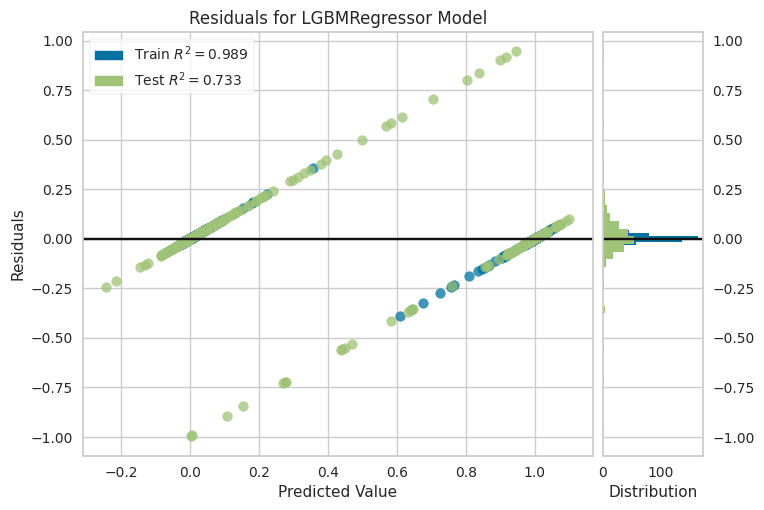

In [93]:
# AUC Plot
plot_model(tuned_best_model)

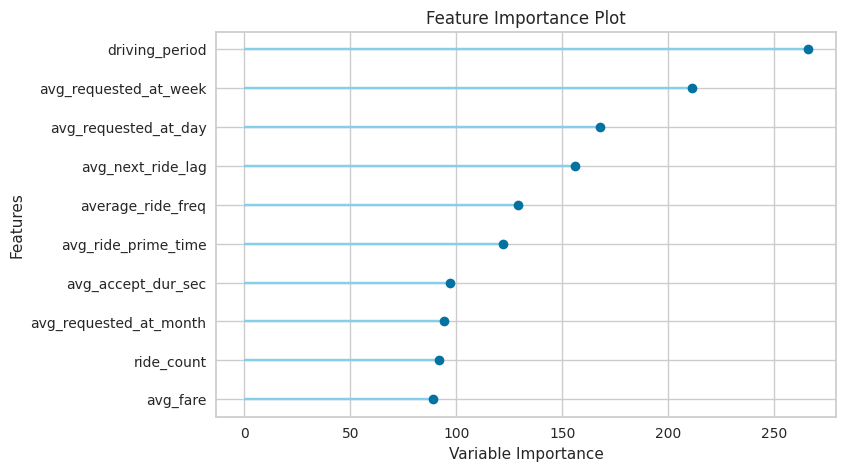

In [94]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

Driving tenure is the best indicator for churn. How long a driver has been on the platform/how long they have driven for is indicator for churning. Meaning those who are new to Lyft are the most prone to churning.

## Segment the driver population to identify driving behavior that may lead to churn

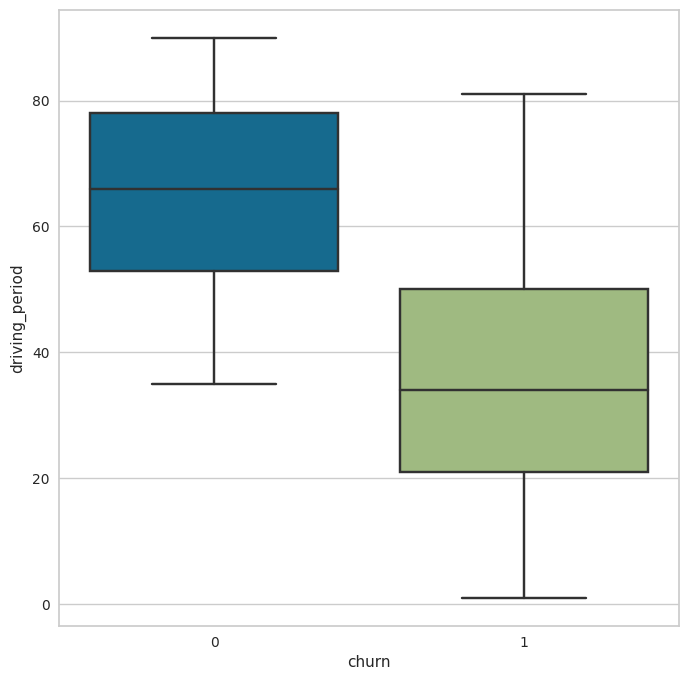

In [95]:
plt.figure(figsize=(8,8))
sns.boxplot(x="churn", y="driving_period", data=df)
plt.show()

There is a difference.

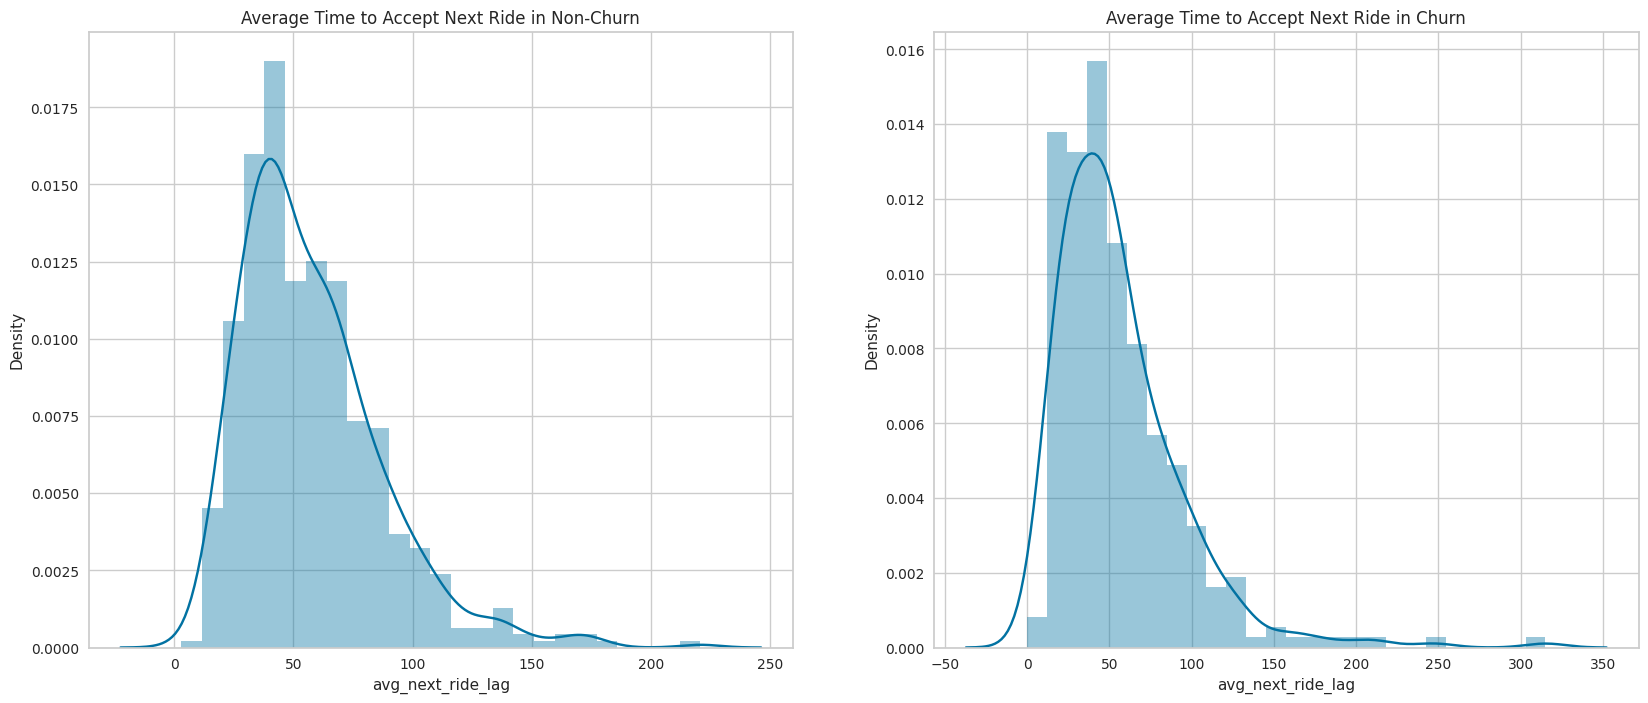

In [109]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.distplot(df[df['churn']== 0]['avg_next_ride_lag'],ax=ax[0])
ax[0].set_title('Average Time to Accept Next Ride in Non-Churn')
sns.distplot(df[df['churn']== 1]['avg_next_ride_lag'],ax=ax[1])
ax[1].set_title('Average Time to Accept Next Ride in Churn')
plt.show()

There is a slight broader distribution with non-churners who end up picking up another ride.

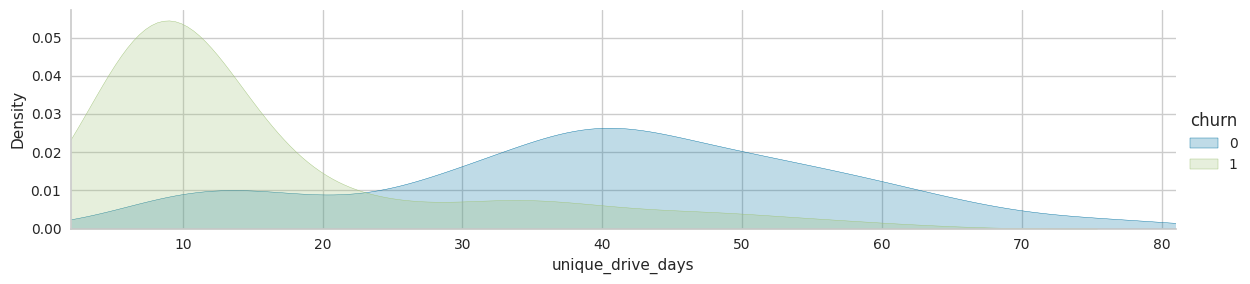

In [97]:
a = sns.FacetGrid(df, hue = 'churn', aspect=4 )
a.map(sns.kdeplot, 'unique_drive_days', shade= True )
a.set(xlim=(df['unique_drive_days'].min() , df['unique_drive_days'].max()))
a.add_legend()

We can see here that as Feature Importance suggested, distinct number of days driver has driven leads to churn. We see here that those who churned only drove for 10 days. This directly relates to the biggest contributor to churn: driver's driving period/tenure.

Text(0, 0.5, 'Average Fare')

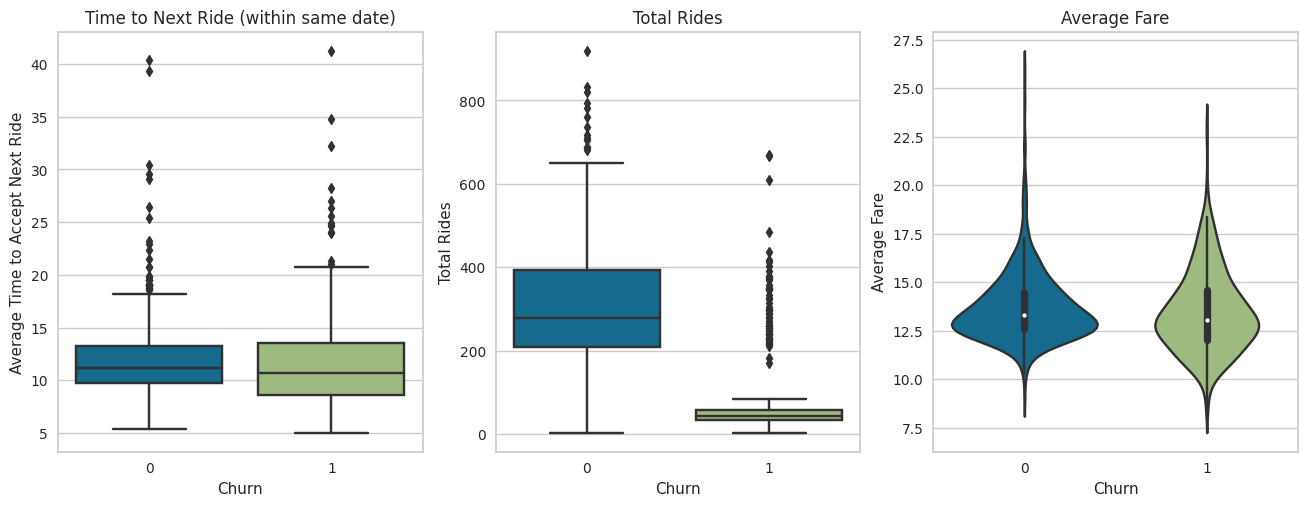

In [110]:
plt.figure(figsize=[16,12])

plt.subplot(231)
sns.boxplot(x="churn", y="avg_accept_dur_sec", data=df)
plt.title('Time to Next Ride (within same date)')
plt.xlabel('Churn')
plt.ylabel('Average Time to Accept Next Ride')

plt.subplot(232)
sns.boxplot(x="churn", y="ride_count", data=df)
plt.title('Total Rides')
plt.xlabel('Churn')
plt.ylabel('Total Rides')

plt.subplot(233)
sns.violinplot(x="churn", y="avg_fare", data=df)
plt.title('Average Fare')
plt.xlabel('Churn')
plt.ylabel('Average Fare')

Biggest difference between churn and non-churn between these three is with total rides which makes sense. Those who drop off Lyft will have overall least amount of rides in 3 month period.

## LTV Feature Importance

In [99]:
# Using Pycaret to see what may contribute to LTV

s2 = setup(df, target = 'ltv', ignore_features = ['driver_id', 'average_val'])

,Description,Value
0,Session id,3400
1,Target,ltv
2,Target type,Regression
3,Original data shape,"(837, 45)"
4,Transformed data shape,"(837, 43)"
5,Transformed train set shape,"(585, 43)"
6,Transformed test set shape,"(252, 43)"
7,Ignore features,2
8,Numeric features,42
9,Preprocess,True


In [100]:
# compare all models
best_model2 = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,44.1583,13395.3570,105.5217,0.9821,0.0562,0.0391,0.5430
gbr,Gradient Boosting Regressor,38.1731,21549.6149,112.2632,0.9751,0.0532,0.0334,0.6220
rf,Random Forest Regressor,55.2458,36065.8799,157.1237,0.9562,0.0720,0.0436,1.0970
et,Extra Trees Regressor,54.5443,38320.6743,159.5413,0.9516,0.0742,0.0450,0.5290
catboost,CatBoost Regressor,57.3795,52818.4239,179.5295,0.9350,0.0828,0.0520,4.9470
dt,Decision Tree Regressor,80.2336,40768.1417,190.0206,0.9362,0.1055,0.0730,0.0380
ada,AdaBoost Regressor,112.1716,42660.7812,191.6155,0.9386,0.2307,0.1973,0.4820
lightgbm,Light Gradient Boosting Machine,75.2050,60738.8894,206.4258,0.9241,0.1004,0.0646,0.5080
ridge,Ridge Regression,241.7028,134629.5507,354.9581,0.7831,0.6073,0.4621,0.1050
lasso,Lasso Regression,242.8942,135484.3950,357.0533,0.7812,0.5996,0.4637,0.1620


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [101]:
# print best_model parameters
print(best_model2)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=3400, ...)


In [102]:
# tune best model
tuned_best_model2 = tune_model(best_model2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,18.6320,1142.2313,33.7969,0.9973,0.0305,0.0242
1,54.1041,17313.0449,131.5790,0.9786,0.0733,0.0478
2,30.1937,4067.8147,63.7794,0.9907,0.0430,0.0318
3,34.7496,3503.2969,59.1887,0.9923,0.0530,0.0394
4,56.2270,19689.4707,140.3192,0.9822,0.0528,0.0361
5,24.6585,1432.4462,37.8477,0.9947,0.0516,0.0374
6,45.1285,40594.8516,201.4816,0.9529,0.0502,0.0296
7,40.4383,9303.8623,96.4565,0.9897,0.0475,0.0315
8,29.4017,7725.7192,87.8961,0.9875,0.0397,0.0281


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


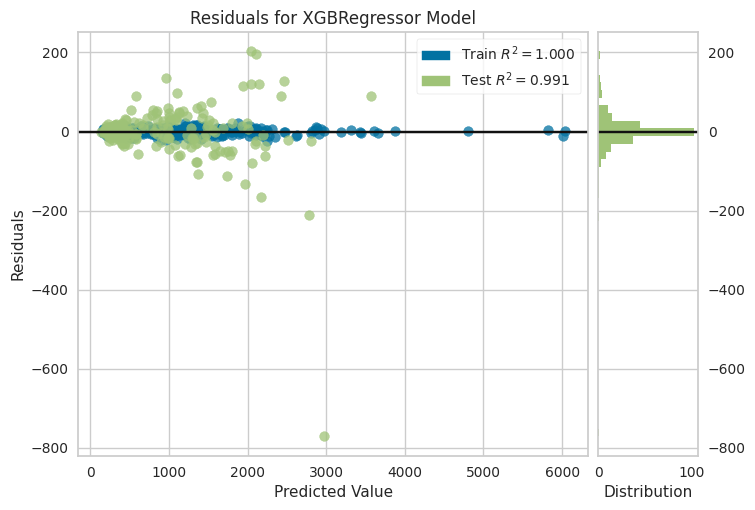

In [103]:
# RMSE Plot
plot_model(tuned_best_model2)

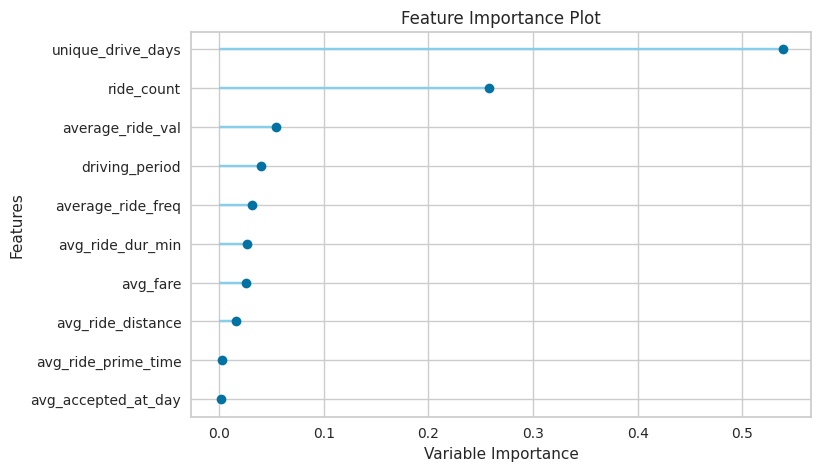

In [104]:
# Feature Importance Plot
plot_model(tuned_best_model2, plot = 'feature')

## Main factors that affect a driver's lifetime value are: 
* number of days driver has driven for
* ride cost
* usual fare for each driver's ride
* how long in distance each ride is
* how long in duration each ride is

<Axes: xlabel='unique_drive_days', ylabel='ltv'>

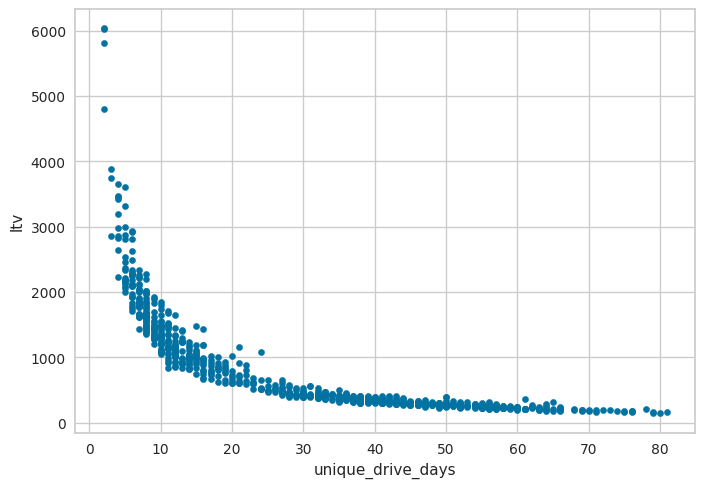

In [105]:
df.plot.scatter(x='unique_drive_days', y='ltv')

This is interesting. (Negative correlation). This shows that the least unique drive days have highest ltv. What this is showing that those who bring greatest value to Lyft drive less (have high volume of rides per day). 

<Axes: xlabel='average_ride_val', ylabel='ltv'>

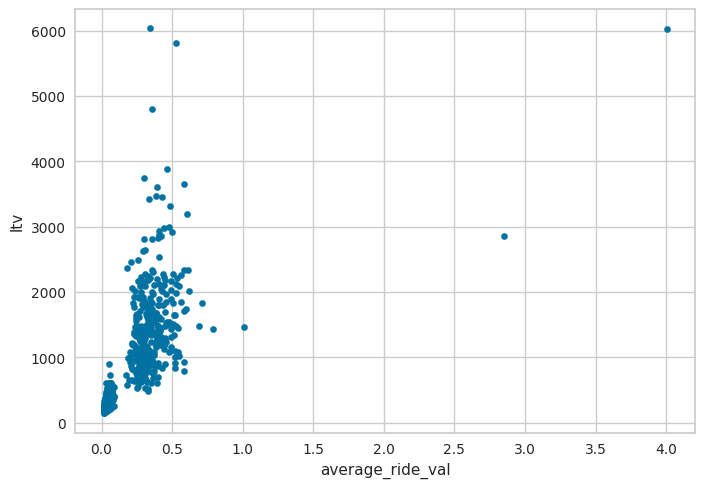

In [106]:
df.plot.scatter(x='average_ride_val',y='ltv')

Average cost per ride does not really show much correlation with ltv.

<Axes: xlabel='avg_fare', ylabel='ltv'>

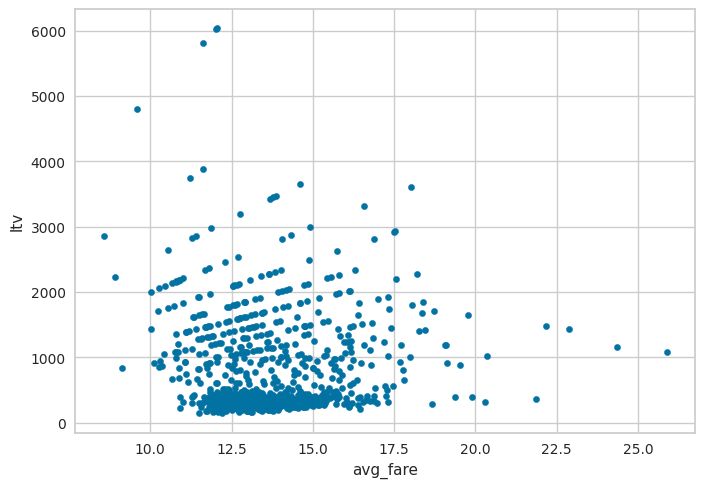

In [107]:
df.plot.scatter(x='avg_fare',y='ltv')

<Axes: xlabel='avg_ride_distance', ylabel='ltv'>

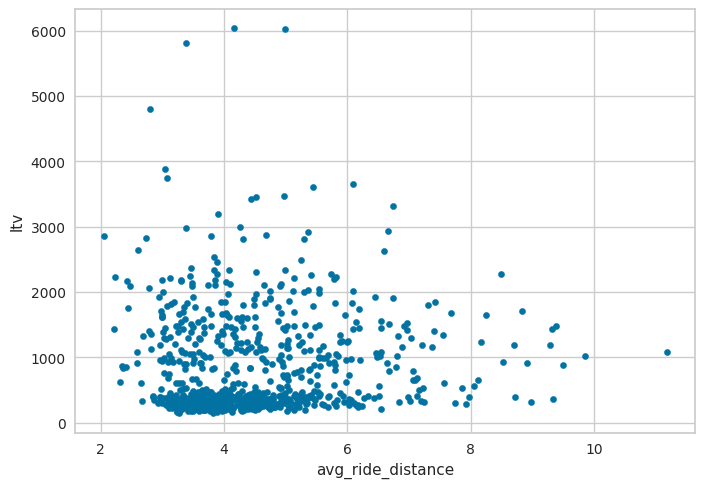

In [108]:
df.plot.scatter(x='avg_ride_distance',y='ltv')

Last two do not have much correlation. Hence, they were low ranked in feature importance.

## Business Recommendations

Detailed in Google Slides Presentation.